In [1]:
import numpy as np

In [2]:
class Node:
    def __init__(self, inputs=[]):
        self.inputs = inputs
        self.outputs = []
        
        for n in self.inputs:
            n.outputs.append(self)
            
        self.value = None
        
        self.gradients = {
            #if is wx+b, this will put the
            #w: x
            #x: w
            #b: 1
        }
        
    def forward(self):
        
        raise NotImplemented
        
    def backward(self):
        
        return NotImplemented
    

In [3]:
class Input(Node):
    #神经网络入口处的第一层节点
    def __init__(self):
        Node.__init__(self)
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {self:0}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost * 1

In [4]:
class Add(Node):
    def __init__(self, nodes):
        Node.__init__(self, nodes)
        
    def forward(self):
        self.value = sum([n.value for n in self.inputs])

In [5]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self, [nodes, weights, bias])

        
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        
        self.value = np.dot(inputs, weights) + bias
        
    def backward(self):
        
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            
            grad_cost = n.gradients[self]
            
            self.gradients[self.inputs[0]] = np.dot(grad_cost, self.inputs[1].value.T)
            
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, grad_cost)
            
            self.gradients[self.inputs[2]] = np.sum(grad_cost, axis=0, keepdims=False)

In [6]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        
    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)
        
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1 - self._sigmoid(self.x))
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            
            self.gradients[self.inputs[0]] = grad_cost * self.partial

In [7]:
class MSE(Node):
    def __init__(self, y_ture, y_hat):
        Node.__init__(self, [y_ture, y_hat])
        
    def forward(self):
        y_true = self.inputs[0].value.reshape(-1, 1)
        y_hat = self.inputs[1].value.reshape(-1, 1)
        assert(y_true.shape == y_hat.shape)
        
        self.diff = y_true - y_hat
        
        self.value = np.mean(self.diff ** 2)
        
    def backward(self):
        n = self.inputs[0].value.shape[0]
        
        self.gradients[self.inputs[0]] = (2 / n) * self.diff
        self.gradients[self.inputs[1]] = -1 * (2 / n) * self.diff

In [8]:
def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()

    for n in  graph[::-1]:
        n.backward()

In [9]:
def topological_sort(feed_dict):
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

In [10]:
def gradient_descent_update(trainable_nodes, learning_rate=1e-3):
    for node in trainable_nodes:
        node.value += -1 * (learning_rate * node.gradients[node])

In [11]:
from sklearn.datasets import load_boston

In [12]:
data = load_boston()

In [13]:
losses = []

In [14]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle, resample
#from miniflow import *

# Load data
data = load_boston()
X_ = data['data']
y_ = data['target']

# Normalize data
X_ = (X_ - np.mean(X_, axis=0)) / np.std(X_, axis=0)

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden, 1)
b2_ = np.zeros(1)

# Neural network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X, W1, b1)
s1 = Sigmoid(l1)
l2 = Linear(s1, W2, b2)
cost = MSE(y, l2)

feed_dict = {
    X: X_,
    y: y_,
    W1: W1_,
    b1: b1_,
    W2: W2_,
    b2: b2_
}

epochs = 5000
# Total number of examples
m = X_.shape[0]
batch_size = 16
steps_per_epoch = m // batch_size

graph = topological_sort(feed_dict)
trainables = [W1, b1, W2, b2]

print("Total number of examples = {}".format(m))

for i in range(epochs):
    loss = 0
    for j in range(steps_per_epoch):
        # Step 1
        # Randomly sample a batch of examples
        X_batch, y_batch = resample(X_, y_, n_samples=batch_size)

        # Reset value of X and y Inputs
        X.value = X_batch
        y.value = y_batch

        # Step 2
        _ = None
        forward_and_backward(_, graph) # set output node not important.

        # Step 3
        rate = 1e-2
    
        gradient_descent_update(trainables, rate)

        loss += graph[-1].value
    
    if i % 100 == 0: 
        print("Epoch: {}, Loss: {:.3f}".format(i+1, loss/steps_per_epoch))
        losses.append(loss)

Total number of examples = 506
Epoch: 1, Loss: 173.030
Epoch: 101, Loss: 5.960
Epoch: 201, Loss: 4.745
Epoch: 301, Loss: 5.021
Epoch: 401, Loss: 3.968
Epoch: 501, Loss: 3.991
Epoch: 601, Loss: 3.971
Epoch: 701, Loss: 3.839
Epoch: 801, Loss: 3.868
Epoch: 901, Loss: 3.324
Epoch: 1001, Loss: 3.498
Epoch: 1101, Loss: 3.419
Epoch: 1201, Loss: 3.519
Epoch: 1301, Loss: 3.200
Epoch: 1401, Loss: 3.251
Epoch: 1501, Loss: 3.064
Epoch: 1601, Loss: 3.744
Epoch: 1701, Loss: 3.403
Epoch: 1801, Loss: 3.323
Epoch: 1901, Loss: 3.420
Epoch: 2001, Loss: 3.583
Epoch: 2101, Loss: 3.261
Epoch: 2201, Loss: 2.650
Epoch: 2301, Loss: 3.199
Epoch: 2401, Loss: 3.558
Epoch: 2501, Loss: 3.496
Epoch: 2601, Loss: 2.757
Epoch: 2701, Loss: 3.154
Epoch: 2801, Loss: 3.354
Epoch: 2901, Loss: 3.349
Epoch: 3001, Loss: 3.316
Epoch: 3101, Loss: 2.967
Epoch: 3201, Loss: 2.754
Epoch: 3301, Loss: 3.518
Epoch: 3401, Loss: 3.249
Epoch: 3501, Loss: 2.983
Epoch: 3601, Loss: 3.191
Epoch: 3701, Loss: 3.302
Epoch: 3801, Loss: 3.342
Epoc

In [15]:
import matplotlib.pyplot as plt

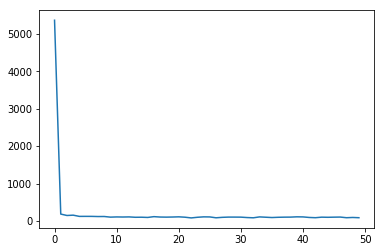

In [16]:
plt.plot(range(len(losses)), losses)

In [17]:
W2.value

array([[ 8.43464374],
       [11.93354049],
       [ 8.93065663],
       [ 3.41273339],
       [ 7.50564794],
       [10.05021513],
       [ 7.29378624],
       [ 8.02869023],
       [ 4.78270501],
       [-6.47126134]])

In [18]:
X_ = data['data']

In [19]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [20]:
import keras

Using TensorFlow backend.


In [21]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [22]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

W0706 22:00:18.885784  6308 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0706 22:00:18.905785  6308 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0706 22:00:18.909786  6308 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0706 22:00:18.991790  6308 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [24]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 0s 65us/step - loss: 84.9846 - mean_squared_error: 84.9846
Epoch 2/5000
506/506 [==============================] - 0s 47us/step - loss: 84.7132 - mean_squared_error: 84.7132
Epoch 3/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0932 - mean_squared_error: 85.0932
Epoch 4/5000
506/506 [==============================] - 0s 38us/step - loss: 84.9376 - mean_squared_error: 84.9376
Epoch 5/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0687 - mean_squared_error: 85.0687
Epoch 6/5000
506/506 [==============================] - 0s 40us/step - loss: 85.7985 - mean_squared_error: 85.7985
Epoch 7/5000
506/506 [==============================] - 0s 40us/step - loss: 84.9294 - mean_squared_error: 84.9294
Epoch 8/5000
506/506 [==============================] - 0s 43us/step - loss: 84.9278 - mean_squared_error: 84.9278
Epoch 9/5000
506/506 [==============================] - 0s 65us/step - loss: 84.

KeyboardInterrupt: 